# Topic Analysis

It is straightforward to use the same approach for topic analysis (e.g., using the Reuters newswire dataset).


Load the data and preprocess them!


In [15]:
from keras.datasets import reuters
from keras.preprocessing import sequence
from keras.utils import to_categorical

(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=20000)
X_train = sequence.pad_sequences(X_train, maxlen=1000)
X_test = sequence.pad_sequences(X_test, maxlen=1000)
y_train, y_test = to_categorical(y_train, 46), to_categorical(y_test, 46)


Let's try the simplest model (Average word embedding):

In [16]:
from keras.models import Sequential
from keras.layers import Masking, GlobalAveragePooling1D, Embedding, Dense
from keras.optimizers import Adam

model = Sequential()
model.add(Masking(mask_value=0, input_shape=(1000,)))
model.add(Embedding(20000, 64, input_length=1000))
model.add(GlobalAveragePooling1D())

model.add(Dense(500, activation='relu'))
model.add(Dense(46, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=128, verbose=2)


/home/nick/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'embedding_2' (of type Embedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 1000, 64)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 500)            │        32,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 46)             │        23,046 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,335,546 (5.09 MB)

 Trainable params: 1,335,546 (5.09 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
71/71 - 4s - 53ms/step - accuracy: 0.3409 - loss: 2.4756 - val_accuracy: 0.3646 - val_loss: 2.3855
Epoch 2/30
71/71 - 0s - 3ms/step - accuracy: 0.3580 - loss: 2.3577 - val_accuracy: 0.3736 - val_loss: 2.3171
Epoch 3/30
71/71 - 0s - 3ms/step - accuracy: 0.3952 - loss: 2.2442 - val_accuracy: 0.4875 - val_loss: 2.1721
Epoch 4/30
71/71 - 0s - 3ms/step - accuracy: 0.4463 - loss: 2.1163 - val_accuracy: 0.4862 - val_loss: 2.1049
Epoch 5/30
71/71 - 0s - 3ms/step - accuracy: 0.4785 - loss: 2.0481 - val_accuracy: 0.5134 - val_loss: 2.0058
Epoch 6/30
71/71 - 0s - 3ms/step - accuracy: 0.4967 - loss: 1.9742 - val_accuracy: 0.4274 - val_loss: 2.0496
Epoch 7/30
71/71 - 0s - 3ms/step - accuracy: 0.5195 - loss: 1.8904 - val_accuracy: 0.5779 - val_loss: 1.8179
Epoch 8/30
71/71 - 0s - 3ms/step - accuracy: 0.5739 - loss: 1.7287 - val_accuracy: 0.5641 - val_loss: 1.7579
Epoch 9/30
71/71 - 0s - 3ms/step - accuracy: 0.6089 - loss: 1.6177 - val_accuracy: 0.6184 - val_loss: 1.6046
Epoch 10/30
7

Let's extract the learned representation!

In [20]:
import keras
import numpy as np


f = keras.Model(model.layers[0].input, model.layers[3].output)

x_repr = f.predict(X_test)
x_repr = np.float64(x_repr).reshape((X_test.shape[0], 500))
labels = np.argmax(y_test, axis=1)
print(x_repr.shape)
print(labels.shape)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(2246, 500)
(2246,)


This representation can be used for a variety of tasks (exploratory analysis, retrieval, ...). Let's use various techniques to visualize the documents in a 2-D space!

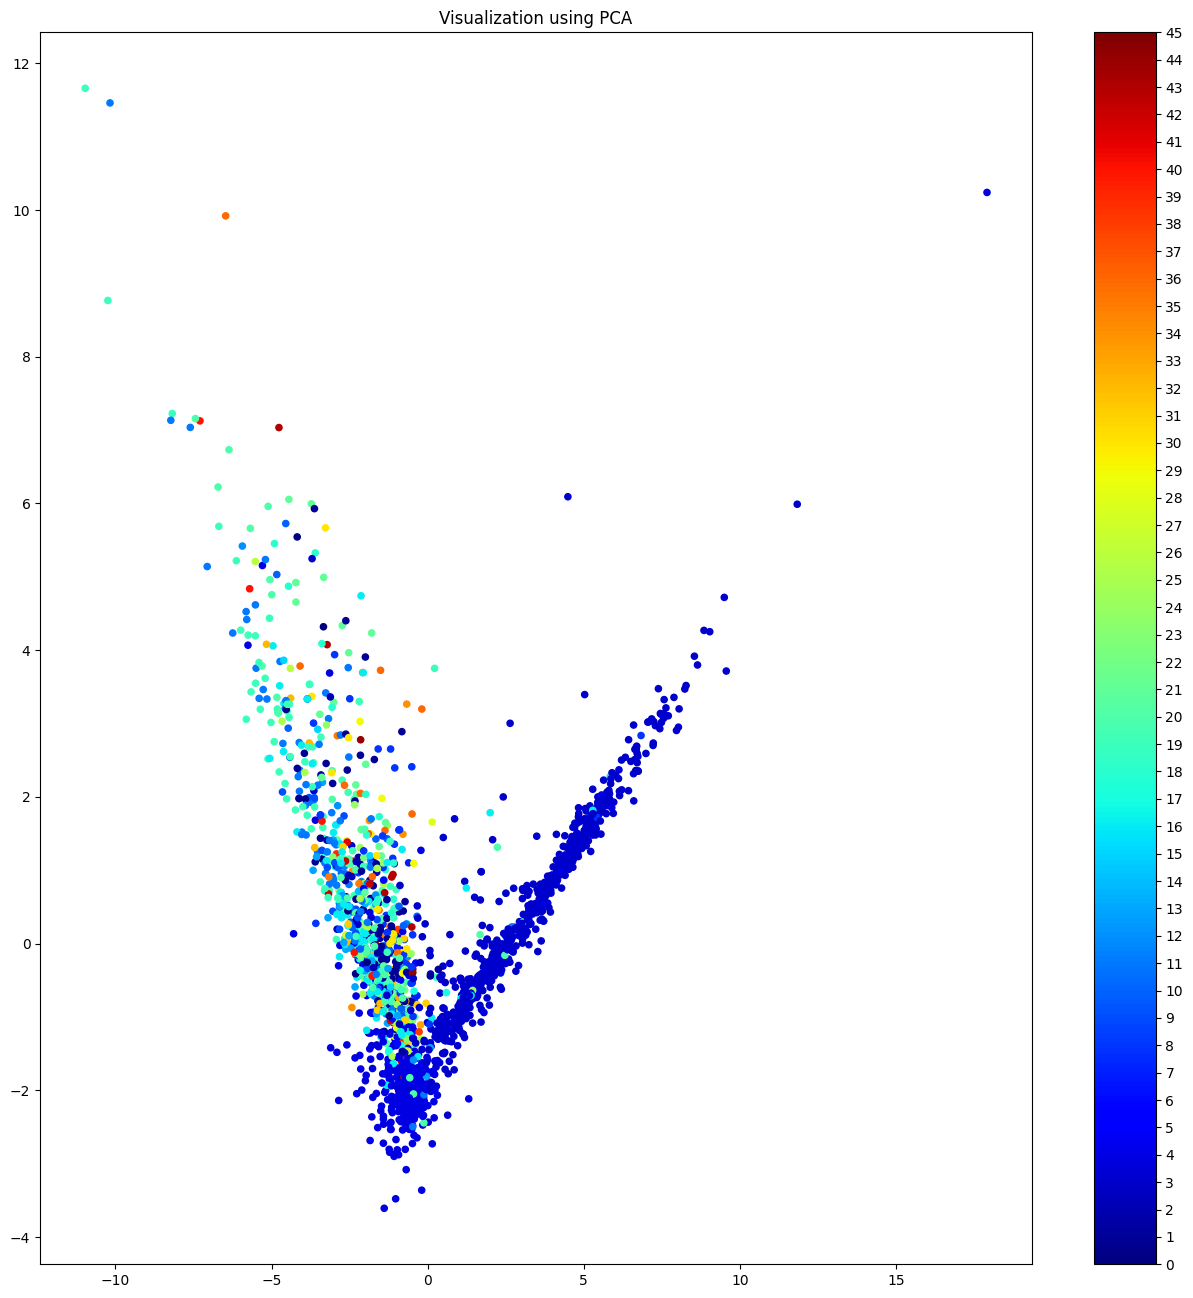

In [21]:
# Perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_repr = pca.fit_transform(x_repr)

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline  

fig, ax = plt.subplots(1,1, figsize=(16,16))

# make the scatter
scat = ax.scatter(pca_repr[:, 0], pca_repr[:,1], c=labels, s=20, cmap=plt.cm.jet)
cb = plt.colorbar(scat, spacing='proportional', ticks=np.linspace(0,46,47))
ax.set_title('Visualization using PCA')
plt.show()

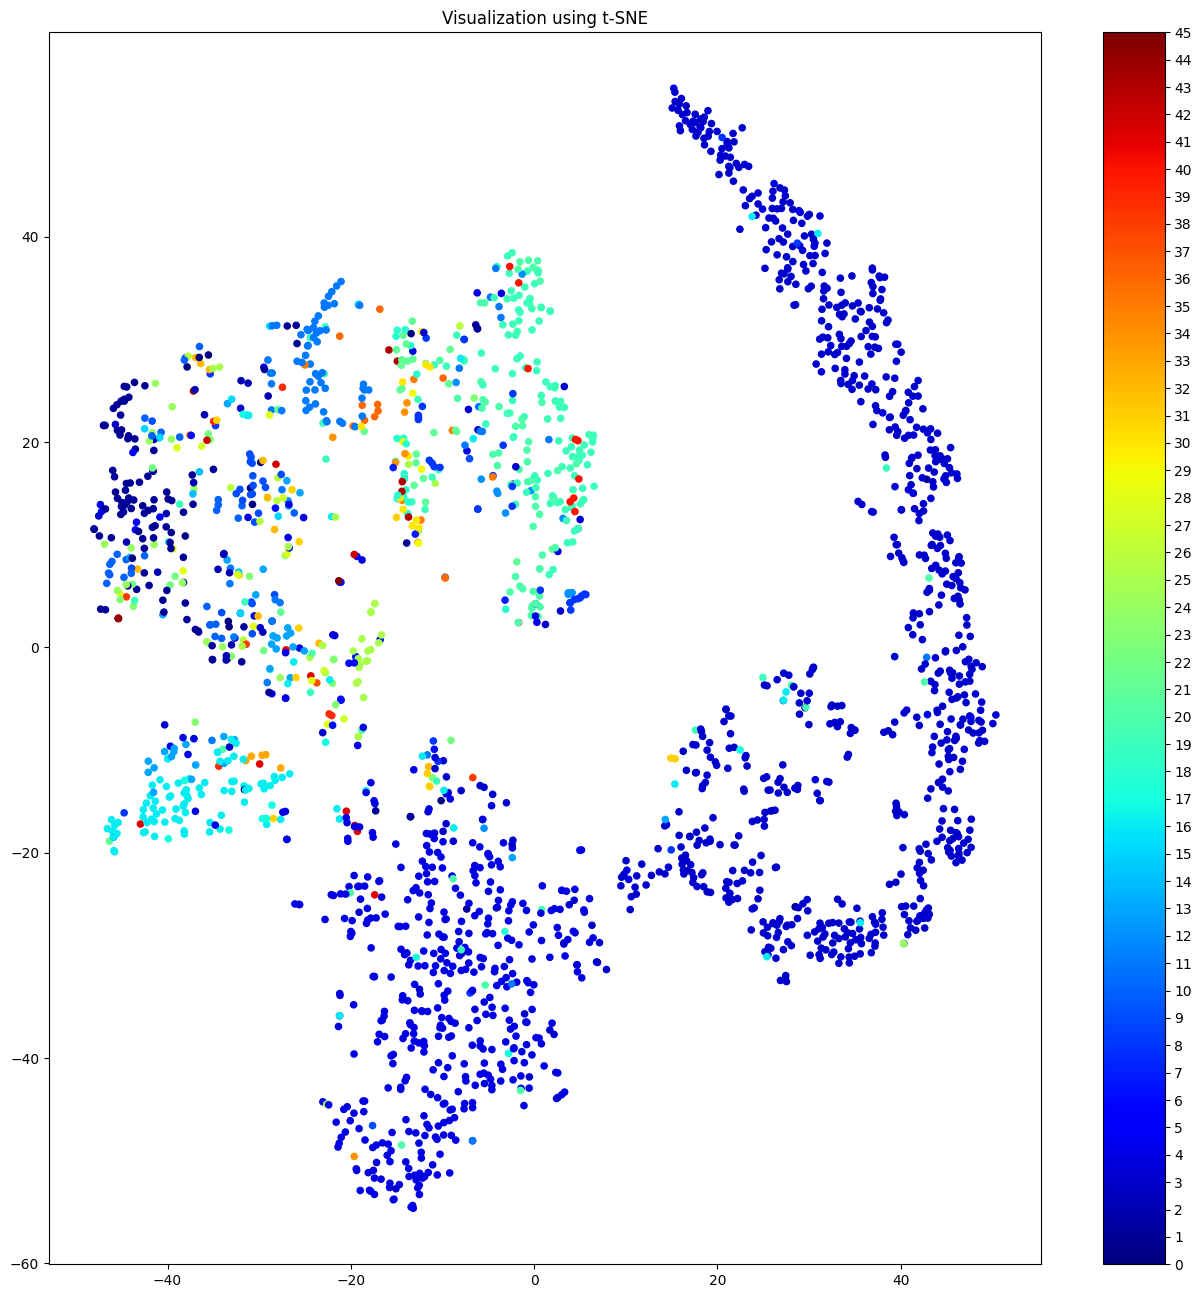

In [22]:
# Perform t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne_repr = tsne.fit_transform(x_repr)

fig, ax = plt.subplots(1,1, figsize=(16,16))

# make the scatter
scat = ax.scatter(tsne_repr[:, 0], tsne_repr[:,1], c=labels, s=20, cmap=plt.cm.jet)
cb = plt.colorbar(scat, spacing='proportional', ticks=np.linspace(0,46,47))
ax.set_title('Visualization using t-SNE')
plt.show()